## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

['./camera_cal/calibration1.jpg', './camera_cal/calibration10.jpg', './camera_cal/calibration11.jpg', './camera_cal/calibration12.jpg', './camera_cal/calibration13.jpg', './camera_cal/calibration14.jpg', './camera_cal/calibration15.jpg', './camera_cal/calibration16.jpg', './camera_cal/calibration17.jpg', './camera_cal/calibration18.jpg', './camera_cal/calibration19.jpg', './camera_cal/calibration2.jpg', './camera_cal/calibration20.jpg', './camera_cal/calibration3.jpg', './camera_cal/calibration4.jpg', './camera_cal/calibration5.jpg', './camera_cal/calibration6.jpg', './camera_cal/calibration7.jpg', './camera_cal/calibration8.jpg', './camera_cal/calibration9.jpg']


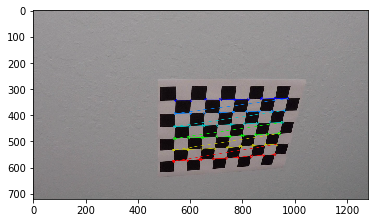

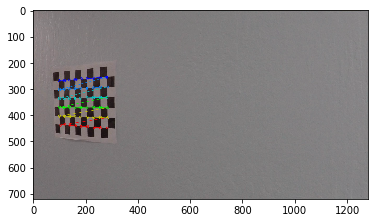

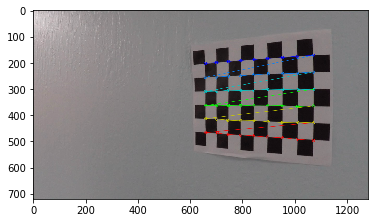

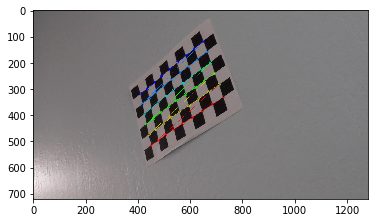

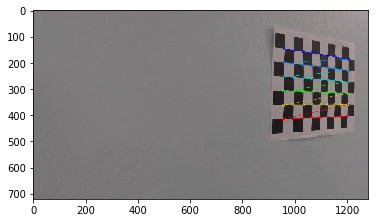

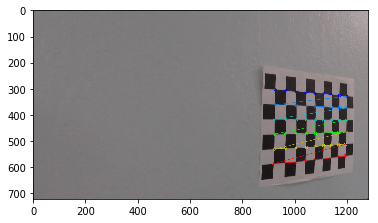

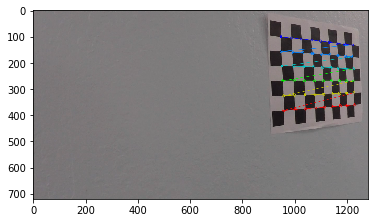

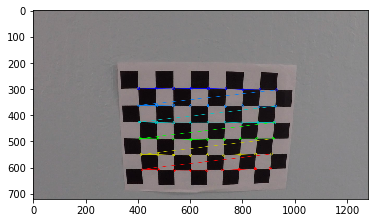

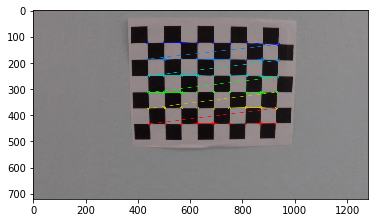

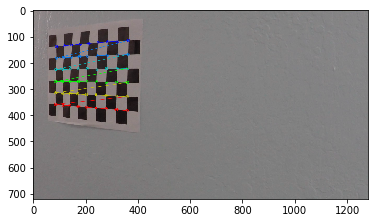

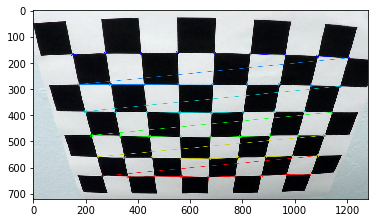

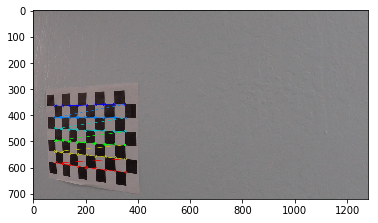

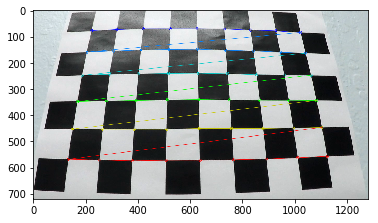

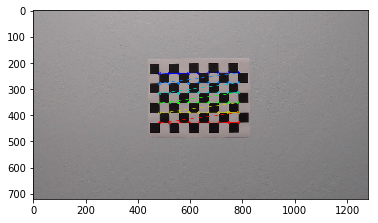

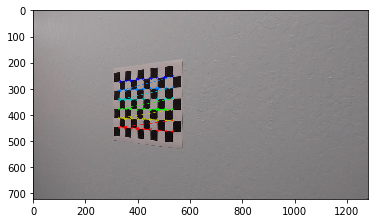

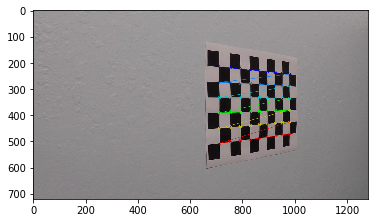

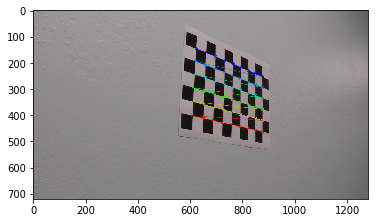

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
%matplotlib inline

def chessboardCaliberation(chessboardImages, nx, ny, displayCorners = False):
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for img in chessboardImages:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            if displayCorners == True:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                plt.figure()
                plt.imshow(img)
                
    return cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
      
# Make a list of calibration images
imagePaths = glob.glob('./camera_cal/calibration*.jpg')
print(imagePaths)
caliberationImages = []
for path in imagePaths:
    caliberationImages.append(cv2.imread(path))
        
#Todo: add saving of objpoints / imgpoints for future loading        
ret, mtx, dist, rvecs, tvecs = chessboardCaliberation(caliberationImages, 9, 6, True)


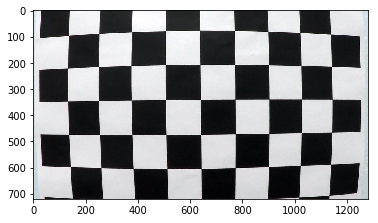

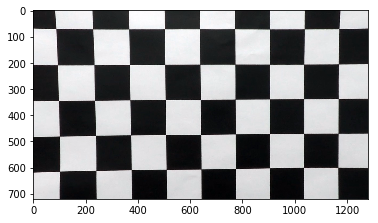

In [2]:
def undistort(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

undist = undistort(caliberationImages[0], mtx, dist)
plt.figure()
plt.imshow(caliberationImages[0])
plt.figure()
plt.imshow(undist)


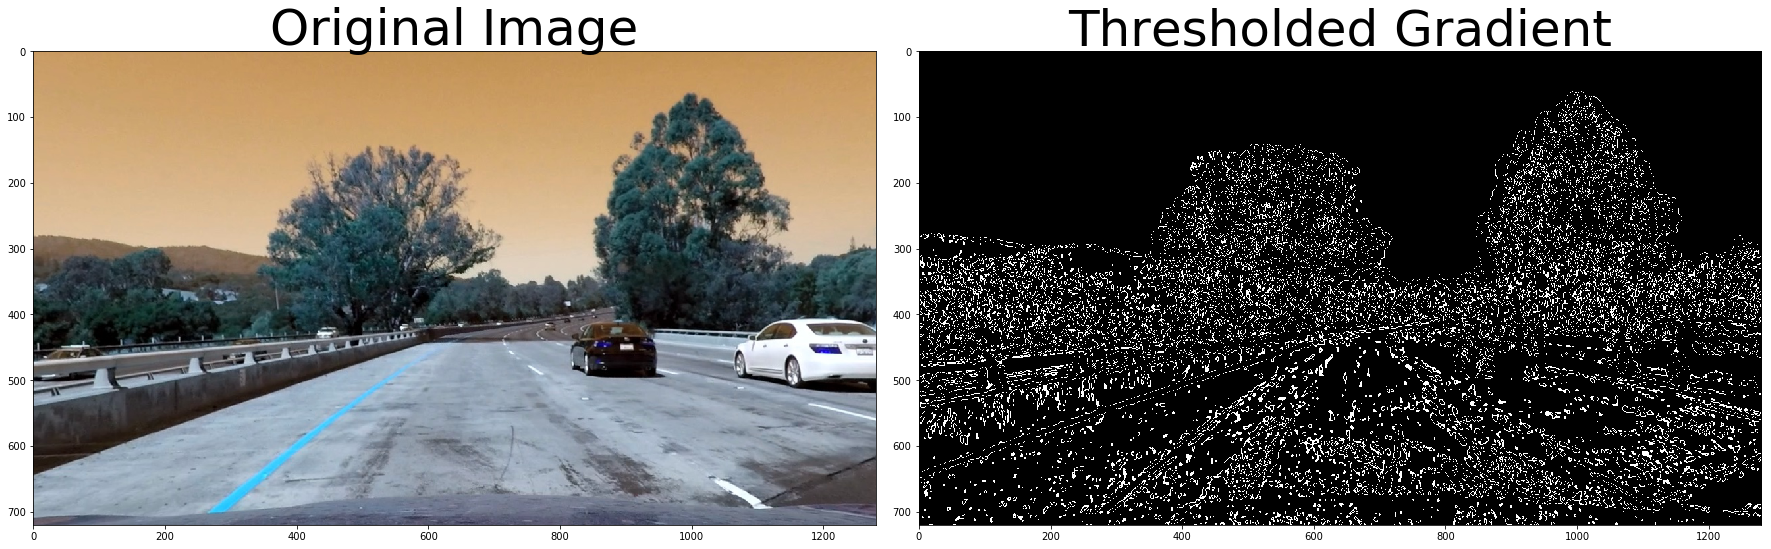

In [9]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

test_image_threshold = undistort(cv2.imread('./test_images/test1.jpg'), mtx, dist)

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(test_image_threshold, orient='x', sobel_kernel=ksize, thresh=(7, 10))
grady = abs_sobel_thresh(test_image_threshold, orient='y', sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(test_image_threshold, sobel_kernel=ksize, mag_thresh=(0, 255))
dir_binary = dir_threshold(test_image_threshold, sobel_kernel=ksize, thresh=(0, np.pi/2))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image_threshold)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform

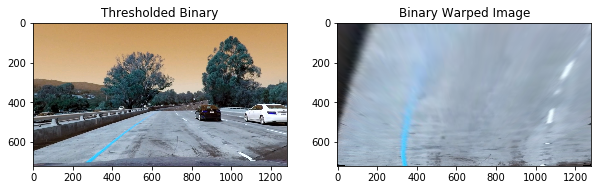

In [19]:
def warpPrspective(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped, M
    
test_image = undistort(cv2.imread('./test_images/test1.jpg'), mtx, dist)
img_size = (test_image.shape[1], test_image.shape[0])
width,height = img_size
offset = 200
src = np.float32([
    [  588,   446 ],
    [  691,   446 ],
    [ 1126,   673 ],
    [  153 ,   673 ]])
dst = np.float32([[offset, 0], [img_size[0] - offset, 0], [img_size[0] - offset, img_size[1]], [offset, img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)

plt.figure(figsize=(10,40))
plt.subplot(1,2,1)
plt.imshow(test_image, cmap='gray')
plt.title('Thresholded Binary')

plt.subplot(1,2,2)
binary_warped = cv2.warpPerspective(test_image, M, (width, height))
plt.imshow(binary_warped, cmap='gray')
plt.title('Binary Warped Image')
